In [1]:
import geopandas as gpd
df = gpd.read_file('/data/acker/ALA/paper2/all_variables.shp')
df = df.rename(columns={'monitor__1':'monitor_coverage_pct', 'classifica':'classification', 'Design Val':'Design Value', 'monitor_co':'monitor_count',
                        'fire_regio':'fire_region', 'mountain_r':'mountain_region', 'desert_reg':'desert_region', 'urban_cate':'urban_category'})
df

,GEOID,PM25_90th,Design Value,classification,diff,abs_diff,monitor_count,cdv_bin,monitor_coverage_pct,dist_km,size,fire_region,mountain_region,desert_region,urban_category,geometry
0,02090,14.333333,12.1,TP,2.233333,2.233333,3,>10,0.008092,85.118385,large,Fire,Mountain,Non-Desert,Non-Urban (<50%),"POLYGON ((-2856843.63046 5312478.28823, -28557..."
1,06063,14.200000,14.0,TP,0.200000,0.200000,1,>10,0.013591,60.606568,large,Fire,Mountain,Non-Desert,Non-Urban (<50%),"POLYGON ((-2118854.71941 2221895.72127, -21186..."
2,06107,12.933334,15.7,TP,-2.766666,2.766666,1,>10,0.007784,100.833209,large,Fire,Mountain,Non-Desert,Non-Urban (<50%),"POLYGON ((-2070309.66155 1752127.22627, -20700..."
3,06023,12.633334,6.9,FP,5.733334,5.733334,1,<7,0.009894,28.714886,large,Fire,Mountain,Non-Desert,Non-Urban (<50%),"POLYGON ((-2353743.03162 2291080.56735, -23521..."
4,06029,12.599999,16.2,TP,-3.600001,3.600001,5,>10,0.023405,82.031806,large,Fire,Mountain,Non-Desert,Non-Urban (<50%),"POLYGON ((-2144173.73318 1689576.62409, -21275..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,02020,4.133333,5.1,TN,-0.966667,0.966667,1,<7,0.020235,66.108117,small,Non-Fire,Mountain,Non-Desert,Non-Urban (<50%),"MULTIPOLYGON (((-3103201.20132 5076792.58623, ..."
532,02110,3.900000,4.6,TN,-0.700000,0.700000,1,<7,0.018594,73.544905,large,Non-Fire,Mountain,Non-Desert,Non-Urban (<50%),"MULTIPOLYGON (((-2392228.37333 4377935.55572, ..."
533,15001,3.633333,4.4,TN,-0.766667,0.766667,5,<7,0.054825,81.864071,large,Fire,Non-Mountain,Non-Desert,Non-Urban (<50%),"POLYGON ((-6074367.2141 1632778.37282, -607415..."
534,15009,3.556667,4.0,TN,-0.443333,0.443333,1,<7,0.035920,78.820617,small,Fire,Non-Mountain,Non-Desert,Non-Urban (<50%),"MULTIPOLYGON (((-6053581.3933 1776189.88692, -..."


In [ ]:
# Replace values in the classification column to rename to alignment vs non-alignment
df['classification'] = df['classification'].replace({
    'TP': 'AP',
    'TN': 'AN',
    'FP': 'NP',
    'FN': 'NN'
})


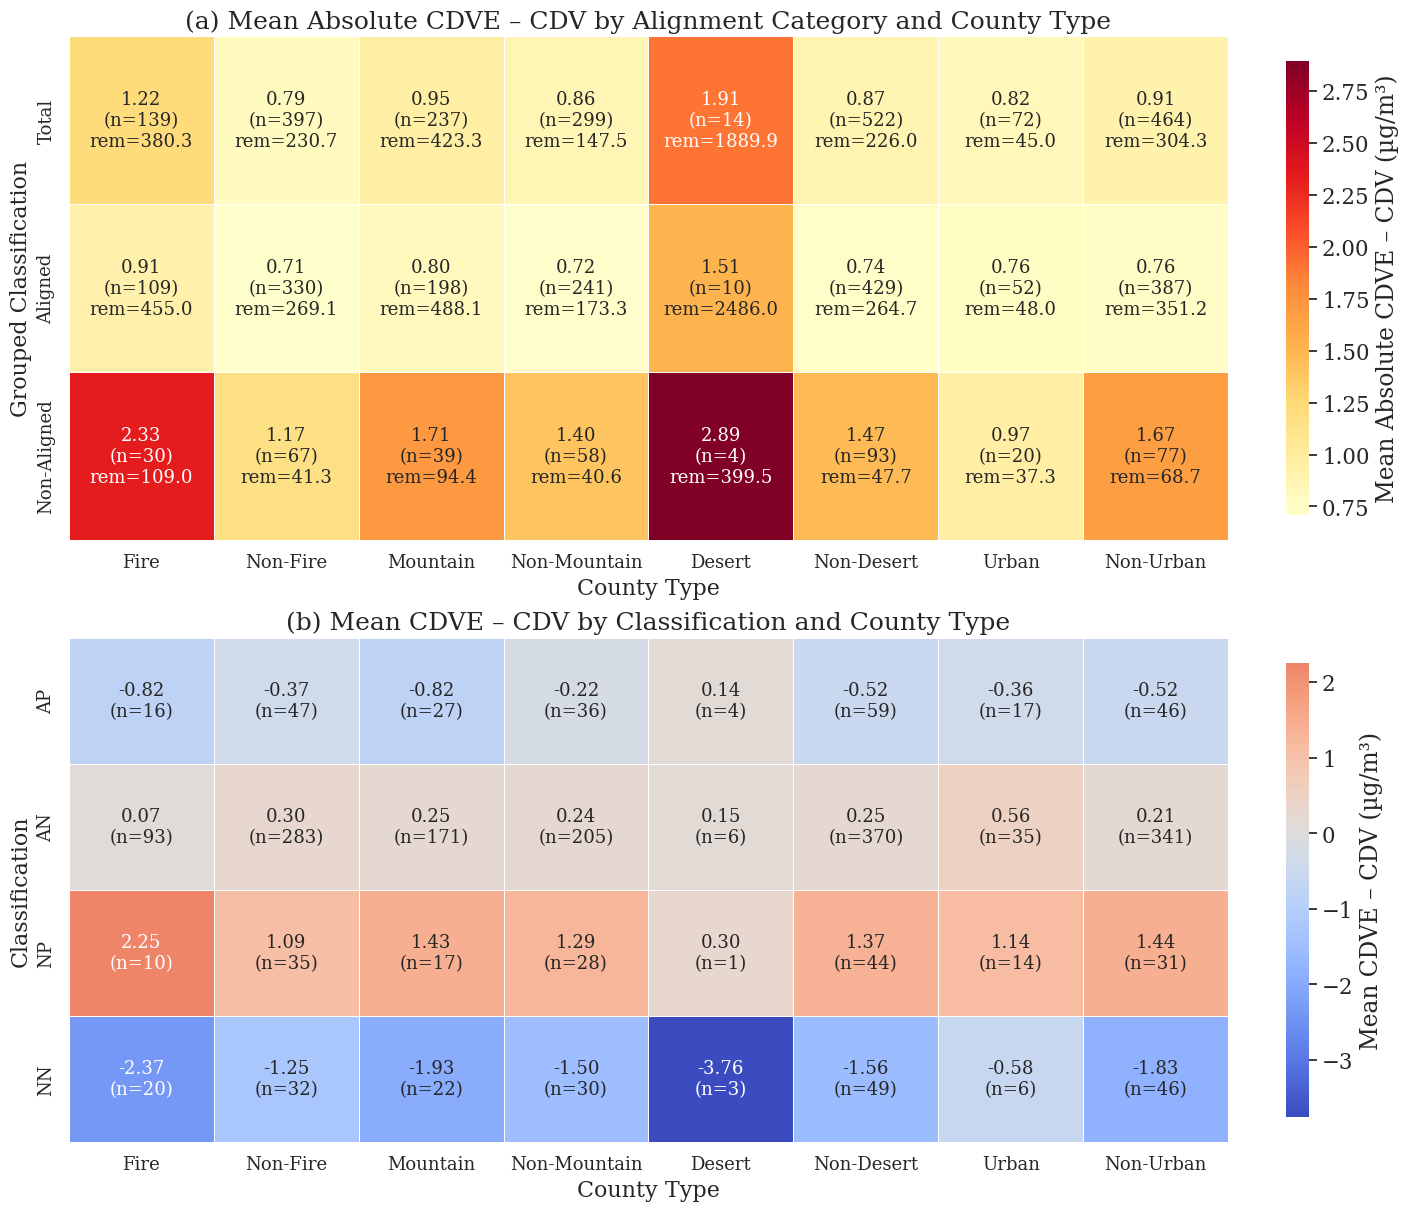

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the county type masks
county_types = {
    'Fire': df['fire_region'] == 'Fire',
    'Non-Fire': df['fire_region'] == 'Non-Fire',
    'Mountain': df['mountain_region'] == 'Mountain',
    'Non-Mountain': df['mountain_region'] == 'Non-Mountain',
    'Desert': df['desert_region'] == 'Desert',
    'Non-Desert': df['desert_region'] == 'Non-Desert',
    'Urban': df['urban_category'] == 'Urban (≥50%)',
    'Non-Urban': df['urban_category'] == 'Non-Urban (<50%)'
}

# Manually specify rem values for grouped classifications
manual_rem_labels = {
    # Grouped classifications (subplot A now)
    'Total': {
        'Fire': 380.3,
        'Non-Fire': 230.7,
        'Mountain': 423.3,
        'Non-Mountain': 147.5,
        'Desert': 1889.9,
        'Non-Desert': 226.0,
        'Urban': 45.0,
        'Non-Urban': 304.3
    },
    'Aligned': {
        'Fire': 455.0,
        'Non-Fire': 269.1,
        'Mountain': 488.1,
        'Non-Mountain': 173.3,
        'Desert': 2486.0,
        'Non-Desert': 264.7,
        'Urban': 48.0,
        'Non-Urban': 351.2
    },
    'Non-Aligned': {
        'Fire': 109.0,
        'Non-Fire': 41.3,
        'Mountain': 94.4,
        'Non-Mountain': 40.6,
        'Desert': 399.5,
        'Non-Desert': 47.7,
        'Urban': 37.3,
        'Non-Urban': 68.7
    }
}

# Collect heatmap data
heatmap_data = []

def add_entry(label, subset, county_type, use_abs=False):
    """Add mean difference and optionally a rem value."""
    values = subset['diff'].abs() if use_abs else subset['diff']
    mean_val = values.mean()
    label_text = f"{mean_val:.2f}\n(n={len(subset)})"

    # Append manual rem if applicable (only for grouped data)
    if use_abs and label in manual_rem_labels and county_type in manual_rem_labels[label]:
        rem_value = manual_rem_labels[label][county_type]
        label_text += f"\nrem={rem_value:.1f}"

    heatmap_data.append({
        'Classification': label,
        'County Type': county_type,
        'Value': mean_val,
        'Label': label_text
    })

# Add individual class data
for county_type, mask in county_types.items():
    for cls in ['AP', 'AN', 'NP', 'NN']:
        subset = df[(df['classification'] == cls) & mask]
        if not subset.empty:
            add_entry(cls, subset, county_type)

# Add grouped class data (use absolute difference)
groupings = {
    'Non-Aligned': ['NP', 'NN'],
    'Aligned': ['AP', 'AN'],
    'Total': ['NP', 'NN', 'AP', 'AN']
}

for group_label, classes in groupings.items():
    for county_type, mask in county_types.items():
        subset = df[df['classification'].isin(classes) & mask]
        if not subset.empty:
            add_entry(group_label, subset, county_type, use_abs=True)

# Convert to DataFrame
heatmap_df = pd.DataFrame(heatmap_data)

# Desired orders
county_type_order = ['Fire', 'Non-Fire', 'Mountain', 'Non-Mountain', 'Desert', 'Non-Desert', 'Urban', 'Non-Urban']
indiv_class_order = ['AP', 'AN', 'NP', 'NN']
group_class_order = ['Total', 'Aligned', 'Non-Aligned']

# Pivot for each subplot
value_matrix_1 = heatmap_df[heatmap_df['Classification'].isin(group_class_order)].pivot(
    index='Classification', columns='County Type', values='Value'
).loc[group_class_order, county_type_order]

label_matrix_1 = heatmap_df[heatmap_df['Classification'].isin(group_class_order)].pivot(
    index='Classification', columns='County Type', values='Label'
).loc[group_class_order, county_type_order]

value_matrix_2 = heatmap_df[heatmap_df['Classification'].isin(indiv_class_order)].pivot(
    index='Classification', columns='County Type', values='Value'
).loc[indiv_class_order, county_type_order]

label_matrix_2 = heatmap_df[heatmap_df['Classification'].isin(indiv_class_order)].pivot(
    index='Classification', columns='County Type', values='Label'
).loc[indiv_class_order, county_type_order]

# Plot subplots
fig, axes = plt.subplots(nrows=2, figsize=(14, 12), constrained_layout=True)
sns.set(font='serif', style='whitegrid', font_scale=1.4)

# Subplot A (was B)
sns.heatmap(
    value_matrix_1,
    annot=label_matrix_1,
    fmt='',
    cmap='YlOrRd',
    linewidths=0.5,
    cbar_kws={'label': 'Mean Absolute CDVE – CDV (µg/m³)', 'shrink': 0.9},
    ax=axes[0],
    annot_kws={"size": 13}
)
axes[0].set_title("(a) Mean Absolute CDVE – CDV by Alignment Category and County Type", fontsize=18)
axes[0].set_ylabel("Grouped Classification", fontsize=16)
axes[0].set_xlabel("County Type", fontsize=16)
axes[0].tick_params(axis='both', labelsize=13)

# Subplot B (was A)
sns.heatmap(
    value_matrix_2,
    annot=label_matrix_2,
    fmt='',
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Mean CDVE – CDV (µg/m³)', 'shrink': 0.9},
    ax=axes[1],
    annot_kws={"size": 13}
)
axes[1].set_title("(b) Mean CDVE – CDV by Classification and County Type", fontsize=18)
axes[1].set_ylabel("Classification", fontsize=16)
axes[1].set_xlabel("County Type", fontsize=16)
axes[1].tick_params(axis='both', labelsize=13)

plt.show()


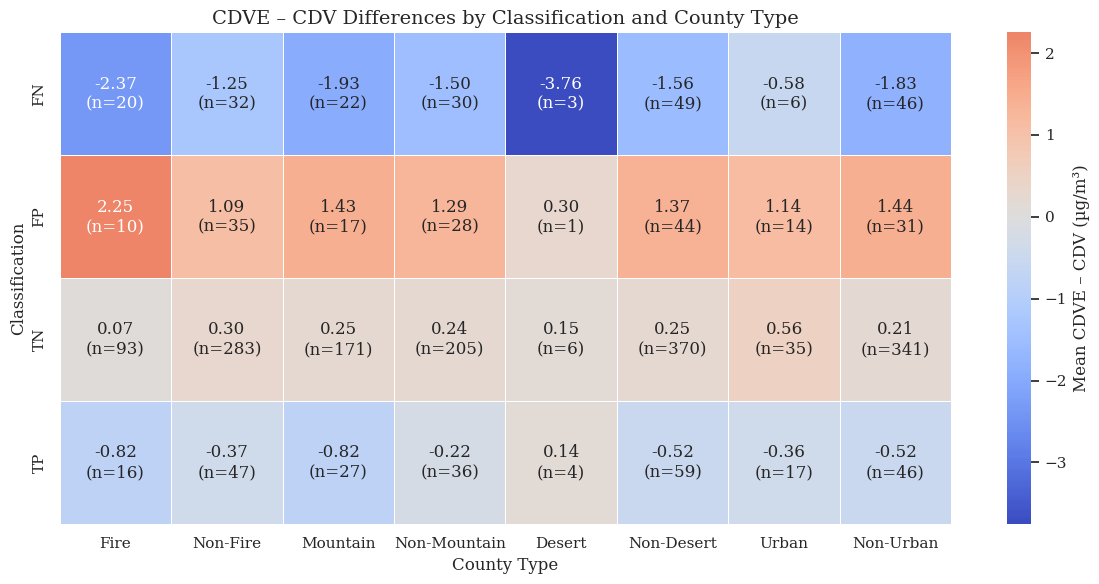

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure 'diff' column is already computed: diff = CDVE - CDV

# County type columns and labels in your dataframe
county_types = {
    'Fire': df['fire_region'] == 'Fire',
    'Non-Fire': df['fire_region'] == 'Non-Fire',
    'Mountain': df['mountain_region'] == 'Mountain',
    'Non-Mountain': df['mountain_region'] == 'Non-Mountain',
    'Desert': df['desert_region'] == 'Desert',
    'Non-Desert': df['desert_region'] == 'Non-Desert',
    'Urban (≥50%)': df['urban_category'] == 'Urban (≥50%)',
    'Non-Urban (<50%)': df['urban_category'] == 'Non-Urban (<50%)'
}

# Collect data for heatmap
heatmap_data = []

for county_type, condition in county_types.items():
    for cls in ['TP', 'TN', 'FP', 'FN']:
        subset = df[(df['classification'] == cls) & condition]
        if not subset.empty:
            mean_diff = subset['diff'].mean()
            n = len(subset)
            label = f"{mean_diff:.2f}\n(n={n})"
            heatmap_data.append({
                'County Type': county_type,
                'Classification': cls,
                'Value': mean_diff,
                'Label': label
            })

# Create DataFrame
heatmap_df = pd.DataFrame(heatmap_data)
# Optional: rename the x-axis column names
heatmap_df['County Type'] = heatmap_df['County Type'].replace({
    'Urban (≥50%)': 'Urban',
    'Non-Urban (<50%)': 'Non-Urban'
})


# Pivot for seaborn heatmap
value_matrix = heatmap_df.pivot(index='Classification', columns='County Type', values='Value')
label_matrix = heatmap_df.pivot(index='Classification', columns='County Type', values='Label')

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.set(font='serif', style='whitegrid')

# Reorder columns for desired layout
desired_order = [
    'Fire', 'Non-Fire',
    'Mountain', 'Non-Mountain',
    'Desert', 'Non-Desert',
    'Urban', 'Non-Urban'
]

# Reindex matrices directly to reorder columns
value_matrix = value_matrix[desired_order]
label_matrix = label_matrix[desired_order]


ax = sns.heatmap(
    value_matrix,
    annot=label_matrix,
    fmt='',
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Mean CDVE – CDV (µg/m³)'}
)


plt.title("CDVE – CDV Differences by Classification and County Type", fontsize=14)
plt.ylabel("Classification")
plt.xlabel("County Type")
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.show()


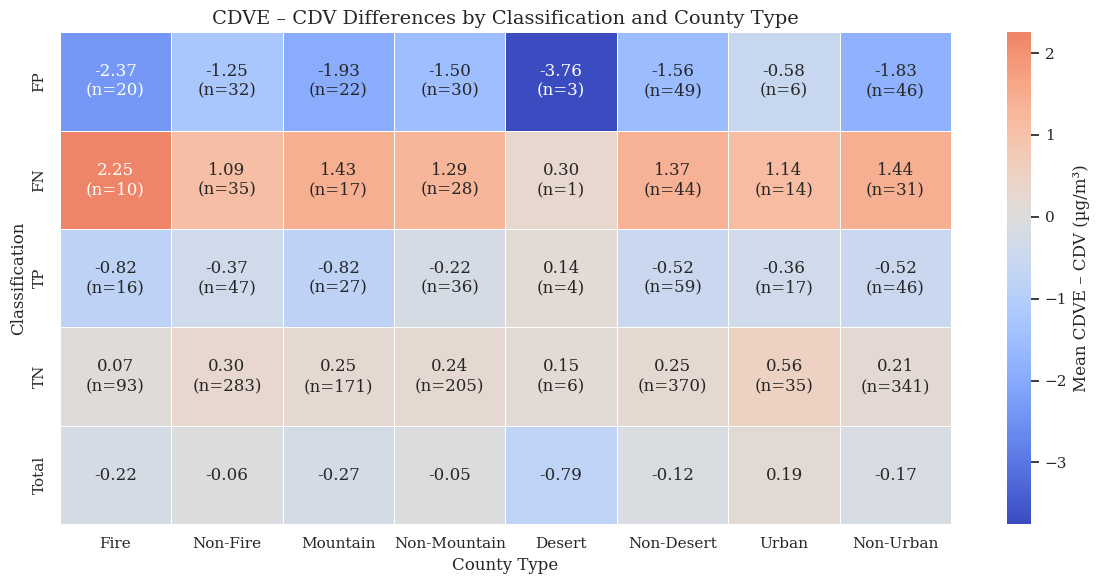

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'diff' column is computed
# df['diff'] = df['CDVE'] - df['CDV']

# County type filters
county_types = {
    'Fire': df['fire_region'] == 'Fire',
    'Non-Fire': df['fire_region'] == 'Non-Fire',
    'Mountain': df['mountain_region'] == 'Mountain',
    'Non-Mountain': df['mountain_region'] == 'Non-Mountain',
    'Desert': df['desert_region'] == 'Desert',
    'Non-Desert': df['desert_region'] == 'Non-Desert',
    'Urban (≥50%)': df['urban_category'] == 'Urban (≥50%)',
    'Non-Urban (<50%)': df['urban_category'] == 'Non-Urban (<50%)'
}

# Prepare data
heatmap_data = []

for county_type, condition in county_types.items():
    for cls in ['FP', 'FN', 'TP', 'TN']:
        subset = df[(df['classification'] == cls) & condition]
        if not subset.empty:
            mean_diff = subset['diff'].mean()
            n = len(subset)
            label = f"{mean_diff:.2f}\n(n={n})"
            heatmap_data.append({
                'County Type': county_type,
                'Classification': cls,
                'Value': mean_diff,
                'Label': label
            })

# Create dataframe
heatmap_df = pd.DataFrame(heatmap_data)

# Simplify labels
heatmap_df['County Type'] = heatmap_df['County Type'].replace({
    'Urban (≥50%)': 'Urban',
    'Non-Urban (<50%)': 'Non-Urban'
})

# Pivot tables
value_matrix = heatmap_df.pivot(index='Classification', columns='County Type', values='Value')
label_matrix = heatmap_df.pivot(index='Classification', columns='County Type', values='Label')

# Reorder columns
desired_order = [
    'Fire', 'Non-Fire',
    'Mountain', 'Non-Mountain',
    'Desert', 'Non-Desert',
    'Urban', 'Non-Urban'
]
value_matrix = value_matrix[desired_order]
label_matrix = label_matrix[desired_order]

# Reorder rows: disagreement → agreement → total
classification_order = ['FP', 'FN', 'TP', 'TN']
value_matrix = value_matrix.reindex(classification_order)
label_matrix = label_matrix.reindex(classification_order)

# Add "Total" row
total_means = value_matrix.mean(axis=0)
total_labels = [f"{val:.2f}\n(n={df[df[ct.replace('Non-', '').lower() + '_region'] == ct]['diff'].count()})"
                if ct in df.columns else f"{val:.2f}" for ct, val in total_means.items()]

value_matrix.loc['Total'] = total_means
label_matrix.loc['Total'] = total_labels

# Plot
plt.figure(figsize=(12, 6))
sns.set(font='serif', style='whitegrid')

ax = sns.heatmap(
    value_matrix,
    annot=label_matrix,
    fmt='',
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Mean CDVE – CDV (µg/m³)'}
)

plt.title("CDVE – CDV Differences by Classification and County Type", fontsize=14)
plt.ylabel("Classification")
plt.xlabel("County Type")
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.show()


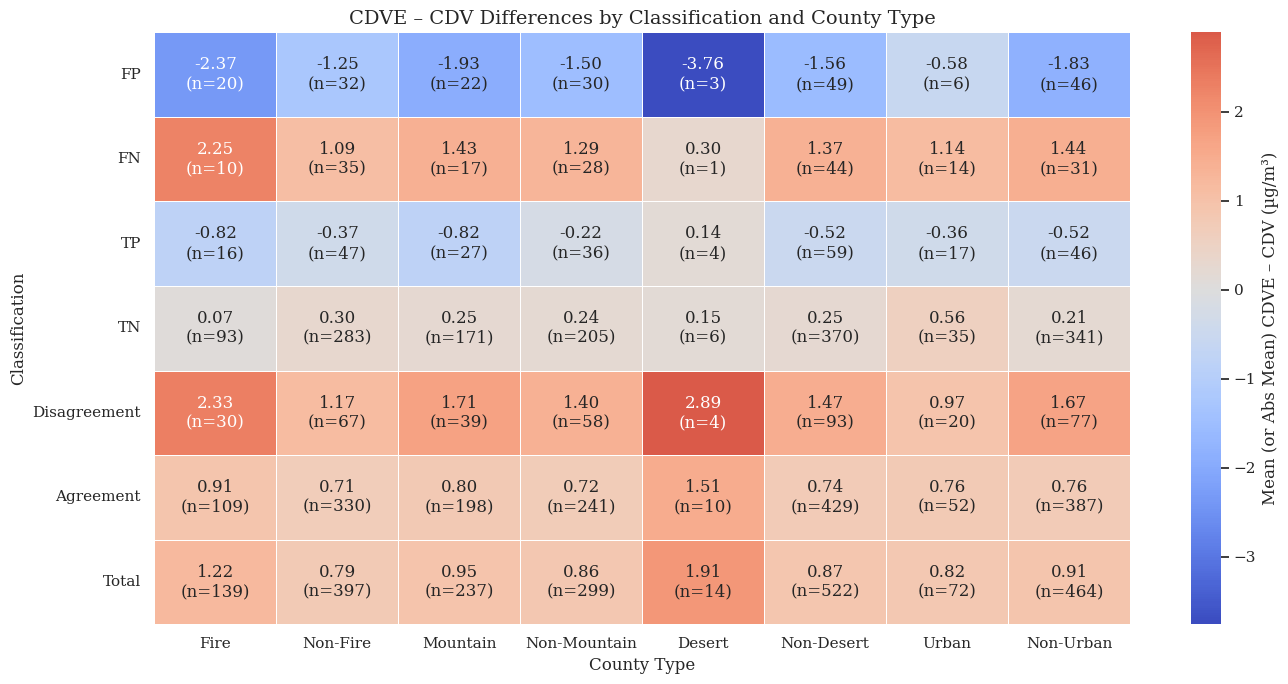

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the county type masks
county_types = {
    'Fire': df['fire_region'] == 'Fire',
    'Non-Fire': df['fire_region'] == 'Non-Fire',
    'Mountain': df['mountain_region'] == 'Mountain',
    'Non-Mountain': df['mountain_region'] == 'Non-Mountain',
    'Desert': df['desert_region'] == 'Desert',
    'Non-Desert': df['desert_region'] == 'Non-Desert',
    'Urban': df['urban_category'] == 'Urban (≥50%)',
    'Non-Urban': df['urban_category'] == 'Non-Urban (<50%)'
}

# Create base rows for individual classification
heatmap_data = []

def add_entry(label, subset, county_type):
    mean_diff = subset['diff'].mean()
    label_text = f"{mean_diff:.2f}\n(n={len(subset)})"
    heatmap_data.append({
        'Classification': label,
        'County Type': county_type,
        'Value': mean_diff,
        'Label': label_text
    })

# Individual classes
for county_type, mask in county_types.items():
    for cls in ['FP', 'FN', 'TP', 'TN']:
        subset = df[(df['classification'] == cls) & mask]
        if not subset.empty:
            add_entry(cls, subset, county_type)

# Grouped rows (Disagreement, Agreement, Total)
groupings = {
    'Disagreement': ['FP', 'FN'],
    'Agreement': ['TP', 'TN'],
    'Total': ['FP', 'FN', 'TP', 'TN']
}

for group_label, classes in groupings.items():
    for county_type, mask in county_types.items():
        subset = df[df['classification'].isin(classes) & mask]
        if not subset.empty:
            abs_diff = subset['diff'].abs()
            mean_abs_diff = abs_diff.mean()
            label = f"{mean_abs_diff:.2f}\n(n={len(subset)})"
            heatmap_data.append({
                'Classification': group_label,
                'County Type': county_type,
                'Value': mean_abs_diff,
                'Label': label
            })

# Build dataframe
heatmap_df = pd.DataFrame(heatmap_data)

# Desired order
classification_order = ['FP', 'FN', 'TP', 'TN',  'Disagreement', 'Agreement', 'Total']
county_type_order = ['Fire', 'Non-Fire', 'Mountain', 'Non-Mountain', 'Desert', 'Non-Desert', 'Urban', 'Non-Urban']

# Pivot and reorder
value_matrix = heatmap_df.pivot(index='Classification', columns='County Type', values='Value').loc[classification_order, county_type_order]
label_matrix = heatmap_df.pivot(index='Classification', columns='County Type', values='Label').loc[classification_order, county_type_order]

# Plot
plt.figure(figsize=(14, 7))
sns.set(font='serif', style='whitegrid')

ax = sns.heatmap(
    value_matrix,
    annot=label_matrix,
    fmt='',
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Mean (or Abs Mean) CDVE – CDV (µg/m³)'}
)

plt.title("CDVE – CDV Differences by Classification and County Type", fontsize=14)
plt.ylabel("Classification")
plt.xlabel("County Type")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


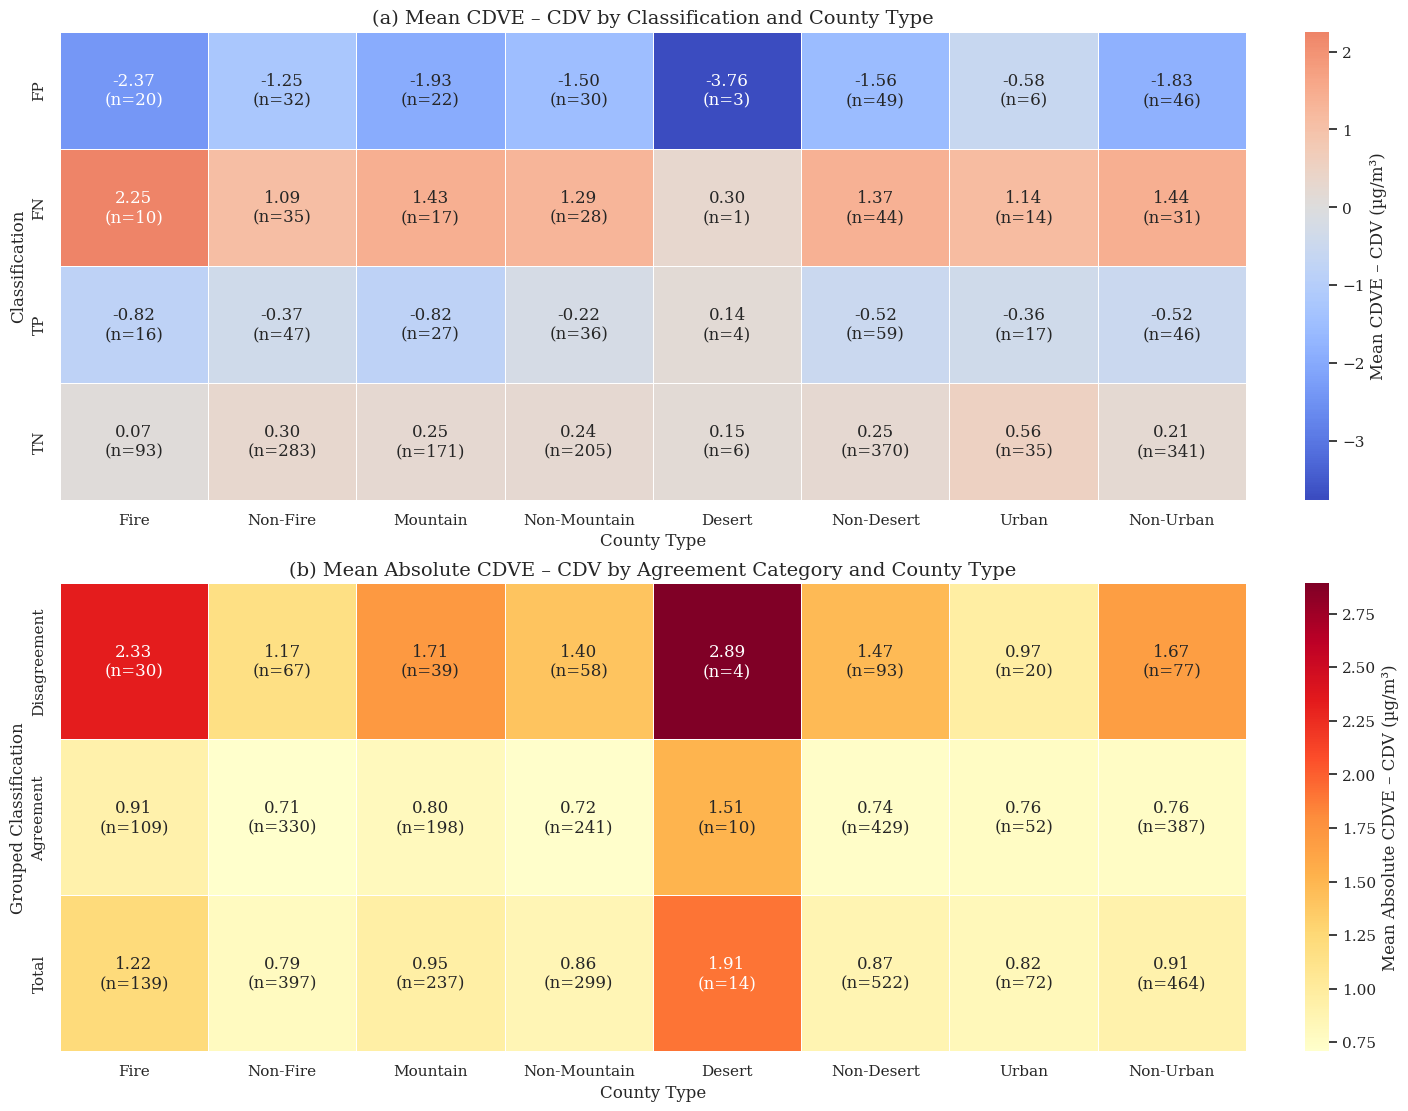

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the county type masks
county_types = {
    'Fire': df['fire_region'] == 'Fire',
    'Non-Fire': df['fire_region'] == 'Non-Fire',
    'Mountain': df['mountain_region'] == 'Mountain',
    'Non-Mountain': df['mountain_region'] == 'Non-Mountain',
    'Desert': df['desert_region'] == 'Desert',
    'Non-Desert': df['desert_region'] == 'Non-Desert',
    'Urban': df['urban_category'] == 'Urban (≥50%)',
    'Non-Urban': df['urban_category'] == 'Non-Urban (<50%)'
}

# Collect heatmap data
heatmap_data = []

def add_entry(label, subset, county_type, use_abs=False):
    values = subset['diff'].abs() if use_abs else subset['diff']
    mean_val = values.mean()
    label_text = f"{mean_val:.2f}\n(n={len(subset)})"
    heatmap_data.append({
        'Classification': label,
        'County Type': county_type,
        'Value': mean_val,
        'Label': label_text
    })

# Add individual class data
for county_type, mask in county_types.items():
    for cls in ['FP', 'FN', 'TP', 'TN']:
        subset = df[(df['classification'] == cls) & mask]
        if not subset.empty:
            add_entry(cls, subset, county_type)

# Add grouped class data (use absolute difference)
groupings = {
    'Disagreement': ['FP', 'FN'],
    'Agreement': ['TP', 'TN'],
    'Total': ['FP', 'FN', 'TP', 'TN']
}

for group_label, classes in groupings.items():
    for county_type, mask in county_types.items():
        subset = df[df['classification'].isin(classes) & mask]
        if not subset.empty:
            add_entry(group_label, subset, county_type, use_abs=True)

# Convert to DataFrame
heatmap_df = pd.DataFrame(heatmap_data)

# Desired orders
county_type_order = ['Fire', 'Non-Fire', 'Mountain', 'Non-Mountain', 'Desert', 'Non-Desert', 'Urban', 'Non-Urban']
indiv_class_order = ['FP', 'FN', 'TP', 'TN']
group_class_order = ['Disagreement', 'Agreement', 'Total']

# Pivot for each subplot
value_matrix_1 = heatmap_df[heatmap_df['Classification'].isin(indiv_class_order)].pivot(
    index='Classification', columns='County Type', values='Value'
).loc[indiv_class_order, county_type_order]

label_matrix_1 = heatmap_df[heatmap_df['Classification'].isin(indiv_class_order)].pivot(
    index='Classification', columns='County Type', values='Label'
).loc[indiv_class_order, county_type_order]

value_matrix_2 = heatmap_df[heatmap_df['Classification'].isin(group_class_order)].pivot(
    index='Classification', columns='County Type', values='Value'
).loc[group_class_order, county_type_order]

label_matrix_2 = heatmap_df[heatmap_df['Classification'].isin(group_class_order)].pivot(
    index='Classification', columns='County Type', values='Label'
).loc[group_class_order, county_type_order]

# Plot subplots
fig, axes = plt.subplots(nrows=2, figsize=(14, 11), constrained_layout=True)
sns.set(font='serif', style='whitegrid')

# Subplot A: individual classifications
sns.heatmap(
    value_matrix_1,
    annot=label_matrix_1,
    fmt='',
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Mean CDVE – CDV (µg/m³)'},
    ax=axes[0]
)
axes[0].set_title("(a) Mean CDVE – CDV by Classification and County Type", fontsize=14)
axes[0].set_ylabel("Classification")
axes[0].set_xlabel("County Type")
axes[0].tick_params(axis='x', rotation=0)

# Subplot B: grouped classifications (absolute differences)
sns.heatmap(
    value_matrix_2,
    annot=label_matrix_2,
    fmt='',
    cmap='YlOrRd',
    linewidths=0.5,
    cbar_kws={'label': 'Mean Absolute CDVE – CDV (µg/m³)'},
    ax=axes[1]
)
axes[1].set_title("(b) Mean Absolute CDVE – CDV by Agreement Category and County Type", fontsize=14)
axes[1].set_ylabel("Grouped Classification")
axes[1].set_xlabel("County Type")
axes[1].tick_params(axis='x', rotation=0)

plt.show()


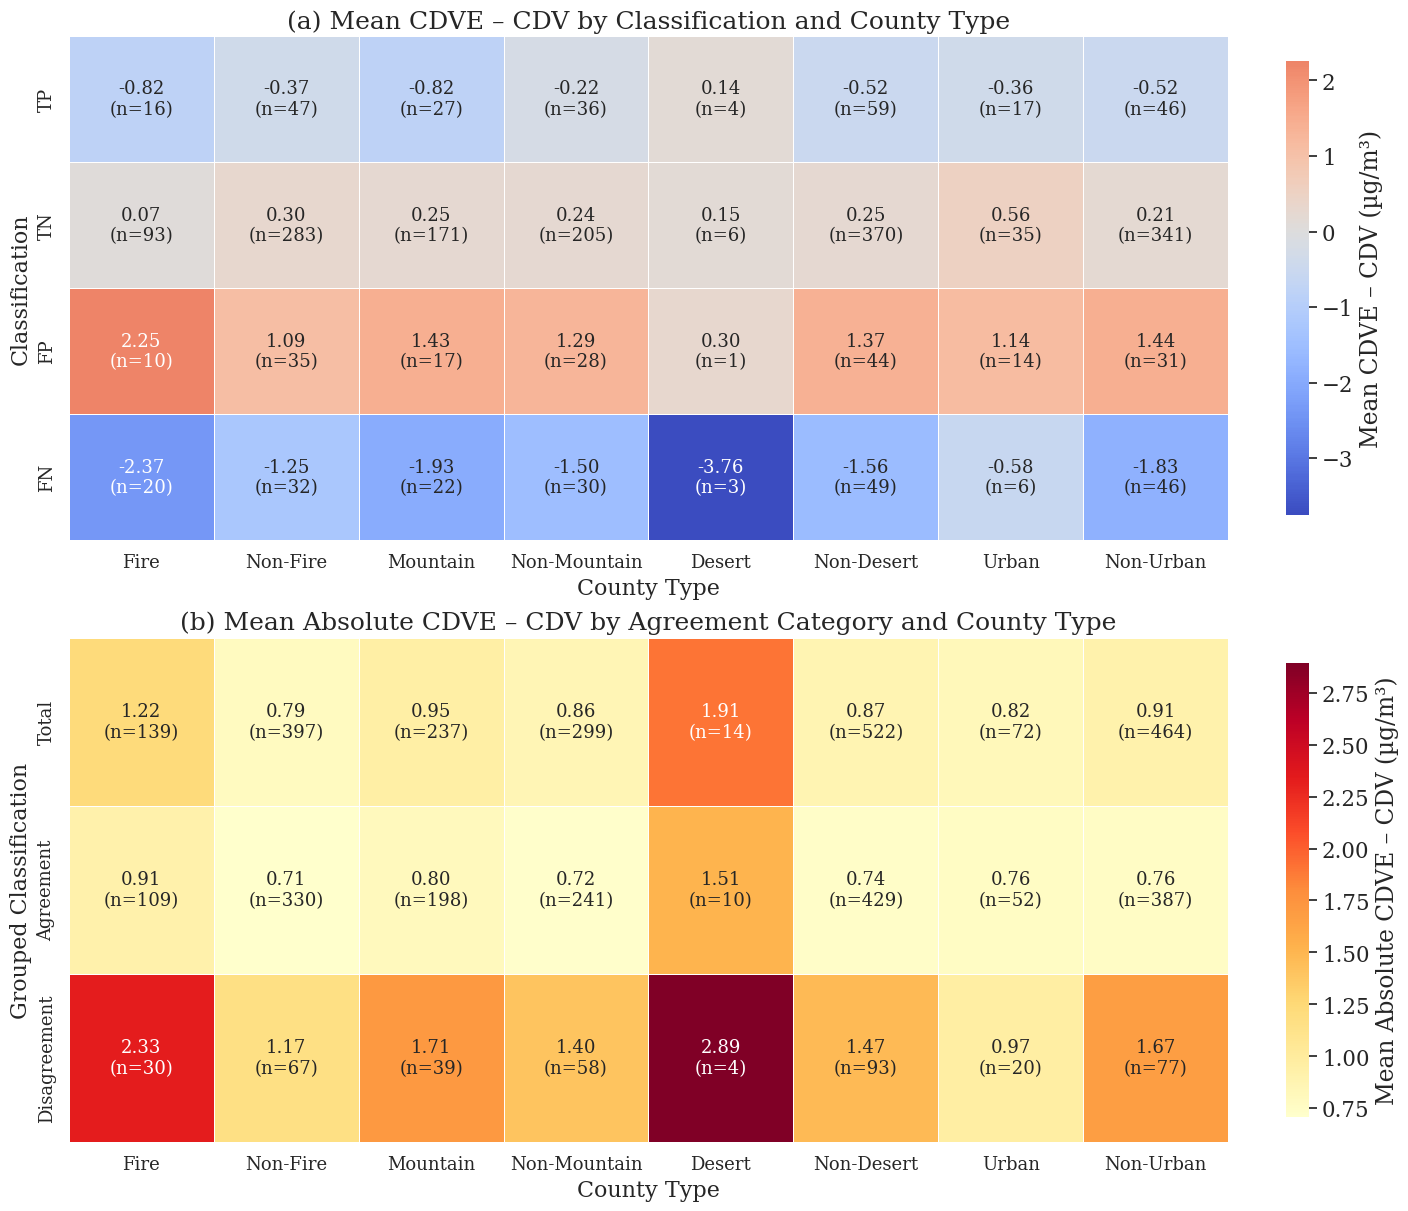

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the county type masks
county_types = {
    'Fire': df['fire_region'] == 'Fire',
    'Non-Fire': df['fire_region'] == 'Non-Fire',
    'Mountain': df['mountain_region'] == 'Mountain',
    'Non-Mountain': df['mountain_region'] == 'Non-Mountain',
    'Desert': df['desert_region'] == 'Desert',
    'Non-Desert': df['desert_region'] == 'Non-Desert',
    'Urban': df['urban_category'] == 'Urban (≥50%)',
    'Non-Urban': df['urban_category'] == 'Non-Urban (<50%)'
}

# Collect heatmap data
heatmap_data = []

def add_entry(label, subset, county_type, use_abs=False):
    values = subset['diff'].abs() if use_abs else subset['diff']
    mean_val = values.mean()
    label_text = f"{mean_val:.2f}\n(n={len(subset)})"
    heatmap_data.append({
        'Classification': label,
        'County Type': county_type,
        'Value': mean_val,
        'Label': label_text
    })

# Add individual class data
for county_type, mask in county_types.items():
    for cls in ['FP', 'FN', 'TP', 'TN']:
        subset = df[(df['classification'] == cls) & mask]
        if not subset.empty:
            add_entry(cls, subset, county_type)

# Add grouped class data (use absolute difference)
groupings = {
    'Disagreement': ['FP', 'FN'],
    'Agreement': ['TP', 'TN'],
    'Total': ['FP', 'FN', 'TP', 'TN']
}

for group_label, classes in groupings.items():
    for county_type, mask in county_types.items():
        subset = df[df['classification'].isin(classes) & mask]
        if not subset.empty:
            add_entry(group_label, subset, county_type, use_abs=True)

# Convert to DataFrame
heatmap_df = pd.DataFrame(heatmap_data)

# Desired orders
county_type_order = ['Fire', 'Non-Fire', 'Mountain', 'Non-Mountain', 'Desert', 'Non-Desert', 'Urban', 'Non-Urban']
indiv_class_order = ['TP', 'TN', 'FP', 'FN']
group_class_order = ['Total', 'Agreement', 'Disagreement']

# Pivot for each subplot
value_matrix_1 = heatmap_df[heatmap_df['Classification'].isin(indiv_class_order)].pivot(
    index='Classification', columns='County Type', values='Value'
).loc[indiv_class_order, county_type_order]

label_matrix_1 = heatmap_df[heatmap_df['Classification'].isin(indiv_class_order)].pivot(
    index='Classification', columns='County Type', values='Label'
).loc[indiv_class_order, county_type_order]

value_matrix_2 = heatmap_df[heatmap_df['Classification'].isin(group_class_order)].pivot(
    index='Classification', columns='County Type', values='Value'
).loc[group_class_order, county_type_order]

label_matrix_2 = heatmap_df[heatmap_df['Classification'].isin(group_class_order)].pivot(
    index='Classification', columns='County Type', values='Label'
).loc[group_class_order, county_type_order]

# Plot subplots with larger fonts
fig, axes = plt.subplots(nrows=2, figsize=(14, 12), constrained_layout=True)
sns.set(font='serif', style='whitegrid', font_scale=1.4)  # Increase global font scale

# Subplot A
sns.heatmap(
    value_matrix_1,
    annot=label_matrix_1,
    fmt='',
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Mean CDVE – CDV (µg/m³)', 'shrink': 0.9},
    ax=axes[0],
    annot_kws={"size": 13}
)
axes[0].set_title("(a) Mean CDVE – CDV by Classification and County Type", fontsize=18)
axes[0].set_ylabel("Classification", fontsize=16)
axes[0].set_xlabel("County Type", fontsize=16)
axes[0].tick_params(axis='both', labelsize=13)

# Subplot B
sns.heatmap(
    value_matrix_2,
    annot=label_matrix_2,
    fmt='',
    cmap='YlOrRd',
    linewidths=0.5,
    cbar_kws={'label': 'Mean Absolute CDVE – CDV (µg/m³)', 'shrink': 0.9},
    ax=axes[1],
    annot_kws={"size": 13}
)
axes[1].set_title("(b) Mean Absolute CDVE – CDV by Agreement Category and County Type", fontsize=18)
axes[1].set_ylabel("Grouped Classification", fontsize=16)
axes[1].set_xlabel("County Type", fontsize=16)
axes[1].tick_params(axis='both', labelsize=13)

plt.show()



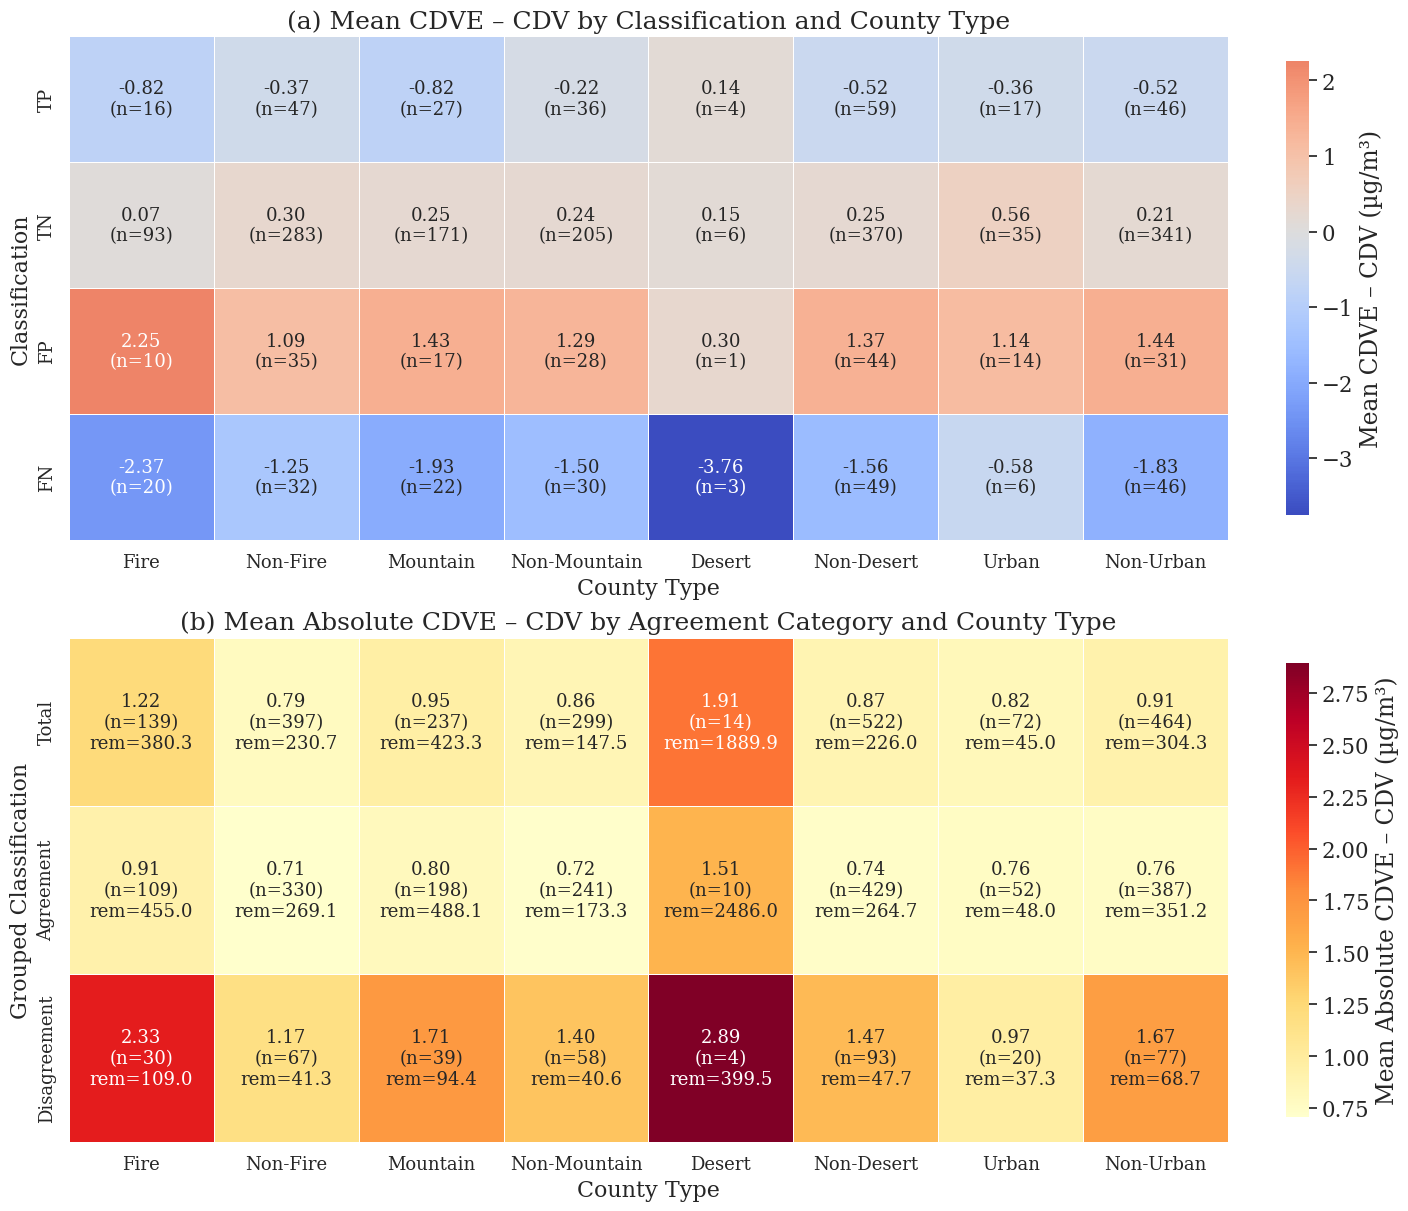

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the county type masks
county_types = {
    'Fire': df['fire_region'] == 'Fire',
    'Non-Fire': df['fire_region'] == 'Non-Fire',
    'Mountain': df['mountain_region'] == 'Mountain',
    'Non-Mountain': df['mountain_region'] == 'Non-Mountain',
    'Desert': df['desert_region'] == 'Desert',
    'Non-Desert': df['desert_region'] == 'Non-Desert',
    'Urban': df['urban_category'] == 'Urban (≥50%)',
    'Non-Urban': df['urban_category'] == 'Non-Urban (<50%)'
}

# 🔥 Manually specify rem values for grouped classifications
manual_rem_labels = {
    # Grouped classifications (subplot B)
    'Total': {
        'Fire': 380.3,
        'Non-Fire': 230.7,
        'Mountain': 423.3,
        'Non-Mountain': 147.5,
        'Desert': 1889.9,
        'Non-Desert': 226.0,
        'Urban': 45.0,
        'Non-Urban': 304.3
    },
    'Agreement': {
        'Fire': 455.0,
        'Non-Fire': 269.1,
        'Mountain': 488.1,
        'Non-Mountain': 173.3,
        'Desert': 2486.0,
        'Non-Desert': 264.7,
        'Urban': 48.0,
        'Non-Urban': 351.2
    },
    'Disagreement': {
        'Fire': 109.0,
        'Non-Fire': 41.3,
        'Mountain': 94.4,
        'Non-Mountain': 40.6,
        'Desert': 399.5,
        'Non-Desert': 47.7,
        'Urban': 37.3,
        'Non-Urban': 68.7
    }
}

# Collect heatmap data
heatmap_data = []

def add_entry(label, subset, county_type, use_abs=False):
    """Add mean difference and optionally a rem value."""
    values = subset['diff'].abs() if use_abs else subset['diff']
    mean_val = values.mean()
    label_text = f"{mean_val:.2f}\n(n={len(subset)})"

    # Append manual rem if applicable (only for subplot B)
    if use_abs and label in manual_rem_labels and county_type in manual_rem_labels[label]:
        rem_value = manual_rem_labels[label][county_type]
        label_text += f"\nrem={rem_value:.1f}"

    heatmap_data.append({
        'Classification': label,
        'County Type': county_type,
        'Value': mean_val,
        'Label': label_text
    })

# Add individual class data
for county_type, mask in county_types.items():
    for cls in ['TP', 'TN', 'FP', 'FN']:
        subset = df[(df['classification'] == cls) & mask]
        if not subset.empty:
            add_entry(cls, subset, county_type)

# Add grouped class data (use absolute difference)
groupings = {
    'Disagreement': ['FP', 'FN'],
    'Agreement': ['TP', 'TN'],
    'Total': ['FP', 'FN', 'TP', 'TN']
}

for group_label, classes in groupings.items():
    for county_type, mask in county_types.items():
        subset = df[df['classification'].isin(classes) & mask]
        if not subset.empty:
            add_entry(group_label, subset, county_type, use_abs=True)

# Convert to DataFrame
heatmap_df = pd.DataFrame(heatmap_data)

# Desired orders
county_type_order = ['Fire', 'Non-Fire', 'Mountain', 'Non-Mountain', 'Desert', 'Non-Desert', 'Urban', 'Non-Urban']
indiv_class_order = ['TP', 'TN', 'FP', 'FN']
group_class_order = ['Total', 'Agreement', 'Disagreement']

# Pivot for each subplot
value_matrix_1 = heatmap_df[heatmap_df['Classification'].isin(indiv_class_order)].pivot(
    index='Classification', columns='County Type', values='Value'
).loc[indiv_class_order, county_type_order]

label_matrix_1 = heatmap_df[heatmap_df['Classification'].isin(indiv_class_order)].pivot(
    index='Classification', columns='County Type', values='Label'
).loc[indiv_class_order, county_type_order]

value_matrix_2 = heatmap_df[heatmap_df['Classification'].isin(group_class_order)].pivot(
    index='Classification', columns='County Type', values='Value'
).loc[group_class_order, county_type_order]

label_matrix_2 = heatmap_df[heatmap_df['Classification'].isin(group_class_order)].pivot(
    index='Classification', columns='County Type', values='Label'
).loc[group_class_order, county_type_order]

# Plot subplots
fig, axes = plt.subplots(nrows=2, figsize=(14, 12), constrained_layout=True)
sns.set(font='serif', style='whitegrid', font_scale=1.4)

# Subplot A
sns.heatmap(
    value_matrix_1,
    annot=label_matrix_1,
    fmt='',
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Mean CDVE – CDV (µg/m³)', 'shrink': 0.9},
    ax=axes[0],
    annot_kws={"size": 13}
)
axes[0].set_title("(a) Mean CDVE – CDV by Classification and County Type", fontsize=18)
axes[0].set_ylabel("Classification", fontsize=16)
axes[0].set_xlabel("County Type", fontsize=16)
axes[0].tick_params(axis='both', labelsize=13)

# Subplot B
sns.heatmap(
    value_matrix_2,
    annot=label_matrix_2,
    fmt='',
    cmap='YlOrRd',
    linewidths=0.5,
    cbar_kws={'label': 'Mean Absolute CDVE – CDV (µg/m³)', 'shrink': 0.9},
    ax=axes[1],
    annot_kws={"size": 13}
)
axes[1].set_title("(b) Mean Absolute CDVE – CDV by Agreement Category and County Type", fontsize=18)
axes[1].set_ylabel("Grouped Classification", fontsize=16)
axes[1].set_xlabel("County Type", fontsize=16)
axes[1].tick_params(axis='both', labelsize=13)

plt.show()
